In [3]:
%pip install stable-baselines3[extra]
%pip install gymnasium 

  Using cached pygame-2.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached Shimmy-1.3.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This could take a while.
  Using cached stable_baselines3-2.3.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached stable_baselines3-2.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached stable_baselines3-2.1.0-py3-none-

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      error in gym setup command: 'extras_require' must be a dictionary whose values are strings or lists of strings containing valid project/version requirement specifiers.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Note: you may need to restart the kernel to use updated packages.


: 

In [82]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class StockMarketEnv(gym.Env):
    def __init__(self, max_len=100, max_inventory=10):
        super(StockMarketEnv, self).__init__()
        self.max_len = max_len
        self.max_inventory = max_inventory
        self.action_space = spaces.Discrete(3)  # 0: wait, 1: buy, 2: sell
        self.observation_space = spaces.Box(
            shape=(self.max_inventory, 2),
            low=-np.inf, high=np.inf,
            dtype=np.float64
        )
        self.history=0
        self.history={"buy":[], "sell":[], "price":[]}
        self.reset()

    def _find_max_profit(self, array):
        assert array[:, 1].sum() > 0
        max_profit = -np.inf
        max_index = 0
        for i in range(self.max_inventory):
            if array[i, 1] == 1 and array[i, 0] > max_profit:
                max_profit = array[i, 0]
                max_index = i
        return max_index

    def reset(self, seed=0):
        self.price = 10000
        self.step_count = 0
        # 상태 정보는 현재 재고 정보와
        # 판매 시 이익량의 정보를 담고 있음.
        self.state = np.zeros((self.max_inventory, 2))
        self.portfolio = 0
        self.purchased_prices = {i: 0 for i in range(self.max_inventory)}
        self.history={"buy":[], "sell":[], "price":[]}
        return self.state, {}

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"

        # Update portfolio and compute reward
        reward = 0
        if action == 1:  # buy
            if 0 in self.state[:, 1]:
                self.portfolio += 1
                available_index = np.where(self.state[:, 1] == 0)[0][0]
                self.purchased_prices[available_index] = self.price
                self.state[available_index, 1] = 1
                self.state[available_index, 0] = 0
                self.history["buy"].append(self.step_count)
        elif action == 2 and self.portfolio > 0:  # sell
            self.portfolio -= 1
            max_profit_item = self._find_max_profit(self.state)
            reward = self.state[max_profit_item, 0]
            self.state[max_profit_item, 0] = 0
            self.state[max_profit_item, 1] = 0
            self.history["sell"].append(self.step_count)

        # 상태 업데이트: 구매했던 가격과 현재 가격의 차이를 계산해 지금 팔면 얻을수 있는 이익값을 상태로 결정
        for i in range(self.max_inventory):
            if self.state[i, 1] == 1: #구매한 슬롯이면 
                self.state[i, 0] = self.price - self.purchased_prices[i]

        # Update price based on random walk
        # self.price += np.random.choice([-1, 1])
        self.price += np.random.randint(-500, 500)
        self.price = max(0, self.price)
        self.history["price"].append(self.price)
        self.step_count += 1
        done = self.step_count >= self.max_len
        # if done:
        #     reward += self.state[:, 0].sum()
        #     for i in range(self.max_inventory):
        #         self.state[i, 0] = 0
        #         self.state[i, 1] = 0

        return self.state, reward, done, done, {}
    
    def render(self, mode='human', close=False):
        print(f"Step: {self.step_count}")
        print(f"Price: {self.price}")
        print(f"Portfolio: {self.portfolio}")
        print(f"Max profit: {max(self.state[:, 0])}")
        print(f"State:\n{self.state}")

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make("CarRacing-v1", domain_randomize=True)

env.reset()

done = False

while not done:
    action = np.random.choice(env.action_space)

In [87]:
def evaluate():
    global plt
    env = StockMarketEnv()
    total_reward = 0
    state = env.reset()
    done = False
    total_reward_history=[]

    while not done:
        action = np.random.choice([0, 1, 2])
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
        total_reward_history.append(total_reward)
        # env.render()
        # print(f"Action: {action}, Reward: {reward}\n")

    print(env.history)

    fig, price1 = plt.subplots()

    price1.plot(range(env.max_len), env.history["price"])
    selling = mpatches.Patch(color='green',label='Sell')
    buying = mpatches.Patch(color='red',label='Buy')
    pricing = mpatches.Patch(color='blue', label="Price")
    rewarding = mpatches.Patch(color='orange', label="Rewards")


    rewards = price1.twinx()
    
    rewards.plot(range(env.max_len), total_reward_history, color='orange')


    for i in env.history["buy"]:
        plt.axvline(i, color='red', alpha=0.1)
    for i in env.history["sell"]:
        plt.axvline(i, color='green', alpha=0.1)
    plt.legend(handles=[selling, buying, pricing, rewarding], loc='lower right')
    plt.show()

    return total_reward



# rewards = []
# for _ in range(100):
#     total_reward = evaluate()
#     rewards.append(total_reward)

# print(np.mean(rewards))
# print(np.max(rewards))
# print(np.min(rewards))


In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

{'buy': [1, 5, 7, 12, 20, 25, 28, 31, 32, 35, 38, 39, 43, 44, 46, 50, 53, 55, 57, 60, 62, 65, 67, 69, 74, 80, 84, 87, 88, 90, 94, 95, 97, 98], 'sell': [2, 6, 9, 15, 21, 26, 33, 36, 40, 41, 42, 47, 48, 56, 58, 66, 68, 71, 72, 75, 76, 78, 79, 81, 86, 91, 93, 96, 99], 'price': [0, 0, 441, 92, 0, 338, 290, 143, 532, 349, 501, 238, 499, 19, 114, 0, 0, 0, 117, 0, 436, 295, 564, 110, 0, 25, 260, 0, 469, 315, 313, 431, 922, 701, 996, 752, 1251, 806, 824, 472, 0, 352, 759, 359, 420, 883, 398, 263, 0, 0, 0, 0, 270, 409, 371, 8, 0, 0, 302, 37, 0, 0, 0, 0, 0, 420, 453, 386, 655, 993, 733, 998, 1360, 1639, 1878, 1535, 1995, 2003, 2444, 2610, 3019, 3439, 3268, 3748, 4189, 3904, 4147, 4500, 4931, 5236, 5170, 4991, 5030, 4563, 4155, 3902, 3877, 4156, 3879, 3443]}


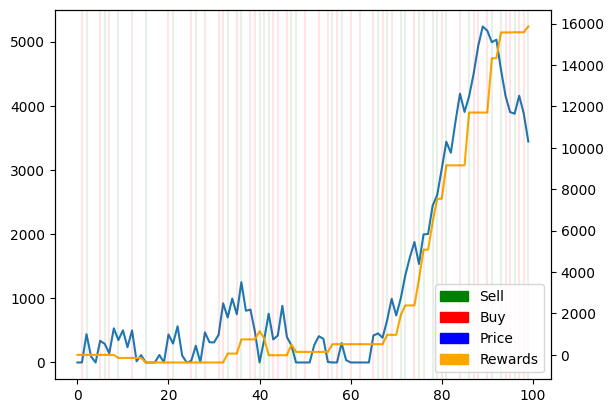

15862.0

In [63]:
evaluate()

In [6]:
%pip install stable_baselines3

Note: you may need to restart the kernel to use updated packages.


In [116]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

# Create the environment
env = StockMarketEnv(max_len=1000)

# Check if the environment follows the gym interface
check_env(env, warn=True)

# Create and train the DQN agent
model = DQN("MlpPolicy", env, verbose=1, learning_rate=0.001, gamma=1)
model.learn(total_timesteps=40000)

# Save the model
model.save("dqn_stock_market")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 3.89e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1315     |
|    time_elapsed     | 3        |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 64.3     |
|    n_updates        | 974      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 1.64e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1292     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8000     |
| train/              |        

{'buy': [0, 1, 2, 7, 9, 11, 12, 13, 14, 15, 16, 17, 26, 27, 28, 29, 33, 35, 37, 40, 41, 43, 44, 45, 49, 51, 52, 54, 55, 59, 60, 61, 62, 68, 108, 126, 131, 133, 134, 135, 136, 146, 148, 150, 151, 157, 161, 164, 168, 177, 178, 179, 180, 181, 182, 186, 187, 190, 193, 194, 195, 205, 206, 207, 208, 210, 214, 215, 216, 217, 218, 219, 225, 226, 227, 228, 230, 231, 232, 282, 295, 299, 303, 307, 310, 317, 320, 333, 346, 350, 351, 353, 370, 371, 374, 375, 376, 382, 386, 390, 393, 396, 401, 404, 405, 406, 414, 415, 416, 417, 421, 422, 423, 424, 430, 432, 434, 435, 436, 437, 440, 441, 446, 448, 449, 452, 453, 454, 455, 461, 462, 466, 467, 469, 470, 471, 472, 473, 481, 482, 483, 485, 487, 488, 491, 492, 493, 494, 495, 496, 499, 507, 508, 509, 511, 513, 514, 515, 518, 520, 523, 525, 526, 528, 532, 533, 534, 535, 536, 540, 541, 542, 543, 546, 547, 548, 558, 570, 571, 574, 575, 576, 577, 581, 582, 583, 584, 585, 586, 590, 591, 597, 598, 600, 601, 603, 604, 608, 611, 620, 623, 624, 626, 627, 628, 629, 

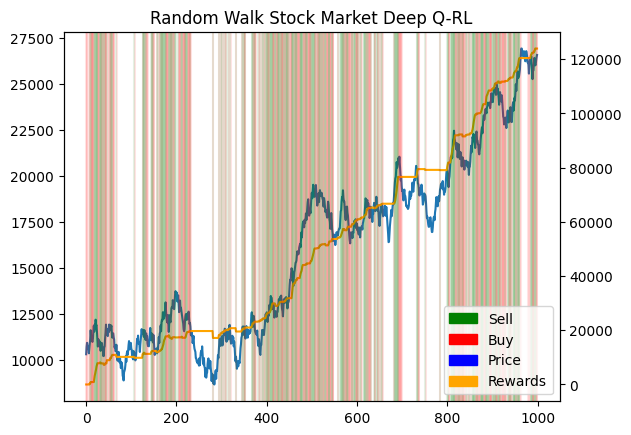

123901.0


In [125]:
def evaluate_dqn():
    # Load the model
    model = DQN.load("dqn_stock_market")

    # Test the trained model
    total_reward = 0
    env.history={"buy":[],"sell":[],"price":[]}
    obs, _ = env.reset()
    done = False
    total_reward_history=[]

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        total_reward_history.append(total_reward)
        # env.render()
        # print(f"Action: {action}, Reward: {reward}\n")
    
    print(env.history)

    fig, price1 = plt.subplots()

    price1.plot(range(env.max_len), env.history["price"])
    selling = mpatches.Patch(color='green',label='Sell')
    buying = mpatches.Patch(color='red',label='Buy')
    pricing = mpatches.Patch(color='blue', label="Price")
    rewarding = mpatches.Patch(color='orange', label="Rewards")

    plt.title("Random Walk Stock Market Deep Q-RL")
    rewards = price1.twinx()
    
    rewards.plot(range(env.max_len), total_reward_history, color='orange')


    for i in env.history["buy"]:
        plt.axvline(i, color='red', alpha=0.1)
    for i in env.history["sell"]:
        plt.axvline(i, color='green', alpha=0.1)
    plt.legend(handles=[selling, buying, pricing, rewarding], loc='lower right')
    plt.show()

    return total_reward


# rewards = []
# for _ in range(100):
#     total_reward = evaluate_dqn()
#     rewards.append(total_reward)

# print(np.mean(rewards))
# print(np.max(rewards))
# print(np.min(rewards))


print(evaluate_dqn())